## AGENDA OF THE NOTEBOOK

1. Build the database with an embeddings model with chromaDB of all the books data and YouTube data
2. Build the RAG pipeline with three configurations

In [1]:
import sys
sys.path.append('../')

from src.book_preprocess import get_book_data

In [2]:
from tqdm import tqdm
import os
import json

import json
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter

sentence_text_parser = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=20
)

def get_book_transcripts_data():
    book_doc_data = get_book_data(100)
    with open('../artifacts/YouTube_API_Transcripts/chunked_transcripts_mba.json', 'r') as file:
        mba_data = json.load(file)

    with open('../artifacts/YouTube_API_Transcripts/chunked_transcripts_undergrad.json', 'r') as file:
        undergrad_data = json.load(file)

    with open('../artifacts/YouTube_API_Transcripts/chunked_misc_transcripts.json', 'r') as file:
        misc_data = json.load(file)
    
    all_data_list = []
    for book_doc in book_doc_data:
        # try:
        if book_doc=={}: continue
        text_data = book_doc['text']
        splitted_chunks = sentence_text_parser.split_text(text_data)
        curr_book_source = book_doc['book_source']
        curr_page_num_coordinates = book_doc['page_num_coordinates']
        for splitted_text in splitted_chunks:
            if len(splitted_text.split(" "))<=10: continue
            all_data_list.append(
                Document(
                    text=splitted_text,
                    metadata={
                        'page_num_coordinates':curr_page_num_coordinates,
                        'book_source':curr_book_source,
                    },
                    excluded_embed_metadata_keys=['page_num_coordinates','book_source'],
                    excluded_llm_metadata_keys=['page_num_coordinates','book_source'],
                )
            )
    for json_data in [undergrad_data,mba_data,misc_data]:
        for youtube_id, text_list in json_data.items():
            # curr_youtube_id_text = ""
            for text_dict in text_list:
                if len(text_dict['text'].split(" "))<=10:continue
                all_data_list.append(
                    Document(
                        text=text_dict['text'],
                        metadata={
                            "youtube_id":youtube_id,
                            "start_timestamp":text_dict['start_time'],
                        },
                        excluded_embed_metadata_keys=['youtube_id','start_timestamp'],
                        excluded_llm_metadata_keys=['youtube_id','start_timestamp'],
                    )
                )
            # break
    return all_data_list

def median(lst):

    lst.sort()
    return lst[len(lst)//2]

def get_book_data(num_para_words:int=50):
    books_folder = "../artifacts/book_hi_res"
    book_data = []
    for book_name in tqdm(os.listdir(books_folder)):
        # print(book_name)
        if book_name.startswith("Corporate_Finance"):continue
        curr_json_path = os.path.join(books_folder, book_name)
        if book_name.startswith("Narrative"):
            start_page = 1
            end_page = 266
        elif book_name.startswith("Little"):
            start_page = 17
            end_page = None
        elif book_name.startswith("Investment_Philosophies"):
            start_page = 1
            end_page = 486
        elif book_name.startswith("Dark"):
            start_page = 1
            end_page = 794
        elif book_name.startswith("Damodaran"):
            start_page = 1
            end_page = 1237
        else:
            start_page = 1
            end_page = None
        
        #Load the data
        with open(curr_json_path, "r") as f:
            json_data = json.load(f)
        x_start = []
        for jd in json_data:
            x_start.append(jd['coordinates'][0][0])
        x_median = median(x_start)
        metadata_book_name = book_name.split(".")[0]
        for jd_idx,jd in enumerate(json_data):
            text_split_list = jd['text'].split(" ")
            num_words = len(text_split_list)
            x_coord = jd['coordinates'][0][0]
            page_num = jd['page_num']
            txt = jd['text']
            # txt = re.sub("\. ",".\n",txt)
            if start_page == 1 and end_page == None:
                pass
            elif start_page>page_num:
                continue
            elif end_page is not None and end_page<page_num:
                continue
            if jd_idx==0 or (x_median-10<=x_coord <= x_median+10 and text_split_list[0].istitle() and num_words>num_para_words):
                book_data.append(
                    {
                        "text": txt+"\n\n",
                    }
                )
                page_coordinates = jd['coordinates'].copy()
                page_coordinates.insert(0,{"page_num":page_num})
                book_data[-1]["page_num_coordinates"] = [page_coordinates]
                book_data[-1]['book_source'] = metadata_book_name
            else:
                prev_idx = book_data[-1]
                if "text" in prev_idx:
                    prev_idx['text'] = prev_idx['text'][:-2] + txt + "\n\n"
                else:
                    prev_idx['text'] = txt + "\n\n"
                page_coordinates = jd['coordinates'].copy()
                page_coordinates.insert(0,{"page_num":page_num})
                if "page_num_coordinates" not in prev_idx:
                    prev_idx["page_num_coordinates"] = [page_coordinates]
                else:
                    prev_idx["page_num_coordinates"].append(page_coordinates)
                if "book_source" not in prev_idx:
                    prev_idx['book_source'] = metadata_book_name
        book_data.append({})
    return book_data

# all_data_list = get_book_transcripts_data()

100%|██████████| 11/11 [00:00<00:00, 17.19it/s]


In [3]:
# num_words = [len(i.text.split(" ")) for i in all_data_list]
# max(num_words)

500

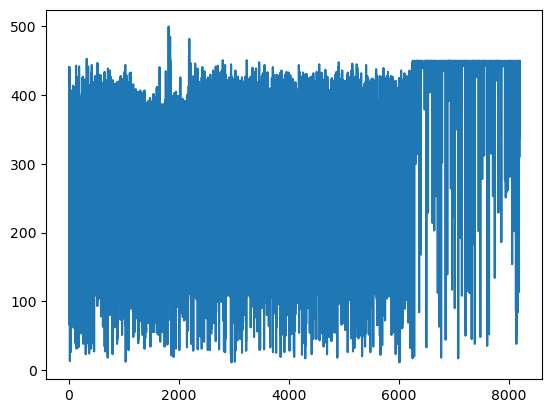

In [4]:
# import matplotlib.pyplot as plt

# plt.plot(num_words)

In [5]:
# min(num_words)

11

In [6]:
# import nomic
# nomic.login(token="nk-tVeW7HFVrX_C7AWKDYIT5YdjMD5f8PhnflQtIZTnWmA")

In [7]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import chromadb
from sentence_transformers import SentenceTransformer
from llama_index.legacy.embeddings.huggingface import HuggingFaceEmbedding


database_name = "AD-PROJECT-NOMIC"
EMBEDDING_MODEL = "nomic-ai/nomic-embed-text-v1.5"
COLLECTION_NAME = "ad-project"

def create_database():
    all_data_list = get_book_transcripts_data()
    
    ad_project_db = chromadb.PersistentClient(path=database_name)
    ad_project_chroma_collection = ad_project_db.get_or_create_collection(COLLECTION_NAME)
    embed_model = HuggingFaceEmbedding(model_name="mixedbread-ai/mxbai-embed-large-v1",embed_batch_size=4)
    vector_store = ChromaVectorStore(chroma_collection=ad_project_chroma_collection)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(
        all_data_list, storage_context=storage_context, embed_model=embed_model,
        show_progress=True
    )

    return index

In [8]:
create_database()

100%|██████████| 11/11 [00:00<00:00, 13.06it/s]


Parsing nodes:   0%|          | 0/8205 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

: 

## DSPY CODE WRITE UP

## MODELS
1. Frozen
2. HyDE
3. Modified HyDE

## TASKS
1. Combined pipeline
2. Use re-rankers (Colbert and cross-encoders)
3. Metadata support

In [1]:
import openai
from dotenv import load_dotenv
import os

load_dotenv(override=True)
openai.api_key = os.environ["OPENAI_API_KEY"]
hf_key = os.environ["HF_API_KEY"]

In [2]:
import dspy
from dspy.retrieve.chromadb_rm import ChromadbRM 
from dsp.utils import dotdict
import chromadb
import openai
import chromadb.utils.embedding_functions as embedding_functions

# EMBEDDING_MODEL = "text-embedding-3-large"
# EMBEDDING_MODEL = "text-embedding-3-small"
# EMBEDDING_MODEL = "nomic-ai/nomic-embed-text-v1"
EMBEDDING_MODEL = "mixedbread-ai/mxbai-embed-large-v1"

# openai_ef = embedding_functions.HuggingFaceEmbeddingFunction(
#                 # api_key=os.environ['OPENAI_API_KEY'],
#                 api_key=hf_key,
#                 model_name=EMBEDDING_MODEL,
#                 # trust_remote_code=True
            # )
COLLECTION_NAME = "ad-project"
DB_PATH = "AD-DB-MXBAI"
# DB_PATH = "AD-DB-NOMIC-v1"
llm = dspy.OpenAI(model="gpt-3.5-turbo-0125",max_tokens = 4096)

# chromadb_client = chromadb.Client(
#     database="AD-DB-LARGE"
# )

# retriever_model = ChromadbRM(collection_name=COLLECTION_NAME,k=10,persist_directory=DB_PATH,embedding_function=openai_ef)

/home/athekunal/AD-Finance-DSPy/dspy-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.legacy.embeddings.openai import OpenAIEmbedding
from llama_index.legacy.embeddings.huggingface import HuggingFaceEmbedding
import chromadb

BASE_DATABASE_NAME = "AD-DB"
TOP_K = 5

def load_database(embedding_source:str,k):
    if "mxbai" in EMBEDDING_MODEL:
        database_name_path = BASE_DATABASE_NAME + "-MXBAI"
        collection_name = COLLECTION_NAME 
    elif "large" in EMBEDDING_MODEL and embedding_source=="openai":
        database_name_path = BASE_DATABASE_NAME + "LARGE"
        collection_name = COLLECTION_NAME + "-large"
    elif "small" in EMBEDDING_MODEL:
        database_name_path = BASE_DATABASE_NAME + "SMALL"
        collection_name = COLLECTION_NAME + "-small"
    elif "nomic" in EMBEDDING_MODEL:
        database_name_path = BASE_DATABASE_NAME + "-NOMIC-v1"
        collection_name = COLLECTION_NAME 
    print(collection_name)
    db2 = chromadb.PersistentClient(path=database_name_path)
    if embedding_source == "openai":
        embed_model = OpenAIEmbedding(model=EMBEDDING_MODEL,api_key=os.environ['OPENAI_API_KEY'])
    elif embedding_source == 'hf':
        embed_model = HuggingFaceEmbedding(model_name=EMBEDDING_MODEL,trust_remote_code=True,device='cuda:0')

    chroma_collection = db2.get_collection(collection_name)
    vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
    index_ = VectorStoreIndex.from_vector_store(
        vector_store,
        embed_model=embed_model,
    )
    retriever = index_.as_retriever(similarity_top_k=k*5)
    return retriever

In [4]:
retriever = load_database("hf",k=5)

ad-project


In [52]:
# !pip install -Uqq einops
# !pip install -Uqq nomic

In [37]:
# retriever = load_database("hf")

In [14]:
ret = retriever.retrieve("Explore the significance of valuation")

In [16]:
ret[0].text

'Every asset, financial as well as real, has a value. The key to successfully investing in and managing these assets lies in understanding not only what the value is but also the sources of the value. Any asset can be valued, but some assets are easier to value than others and the details of valuation will vary from case to case. Thus, the valuation of a share of a real estate property will require different information and follow a different format than the valuation of a publicly traded stock. What is surprising, however, is not the differences in valuation techniques across assets, but the degree of similarity in basic principles. There is undeniably uncertainty associated with valuation. Often that uncertainty comes from the asset being valued, though the valuation model may add to that uncertainty.This chapter lays out a philosophical basis for valuation, together with a discussion of how valuation is or can be used in a variety of frameworks, from portfolio management to corporat

In [40]:
class ChromaDBPipelineRM(dspy.Retrieve):
    def __init__(self,embedding_source:str="hf",k:int=5):
        super().__init__()
        self.retriever = load_database(embedding_source,k)
    
    def forward(self,query):
        llama_index_docs = self.retriever.retrieve(query)
        metadata_list = []
        context_list = []

        for ld in llama_index_docs:
            metadata_list.append(ld.metadata)
            context_list.append(ld.text)
        return dspy.Prediction(
            passages = [dotdict({"long_text": x}) for x in context_list],
            metadata = metadata_list
        )

In [41]:
class DSPyRM(dspy.Module):
    def __init__(self):
        super().__init__()
        self.retriever_model = ChromaDBPipelineRM(embedding_source="hf",k=5)
    
    def forward(self,query,k):
        vectorDB_output = self.retriever_model(query)
        return vectorDB_output.passages,vectorDB_output.metadata

In [5]:
# retriever_model = DSPyRM()
dspy.settings.configure(lm=llm)

In [6]:
class GenerateAnswer(dspy.Signature):
    """Answer questions in detail based on the context."""
    
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="answer in detail")

In [7]:
gpt3_hyde = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=300)

class HyDEGenerateAnswer(dspy.Signature):
    """Answer the question concisely and include as many details as possible"""
    question = dspy.InputField()
    answer = dspy.OutputField(desc="answer concisely with as many details as possible")

In [8]:
from transformers import pipeline
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
MOD_HYDE_MODEL = "distilgpt2-ad-test"
pipe = pipeline("text-generation", model=MOD_HYDE_MODEL,tokenizer=tokenizer)
def get_mod_HyDE_answer(question):
    out = pipe(question,max_new_tokens=300,do_sample=True,min_new_tokens=10)
    return out[0]['generated_text']

In [10]:
# get_mod_HyDE_answer("Explain kps")

In [9]:
from rerankers import Reranker


class RAG(dspy.Module):
    def __init__(self,retriever,algo_type:str="frozen",use_reranker:bool=True,use_cot:bool=True,rerank_docs:int=5):
        super().__init__()
        assert algo_type in ["frozen","hyde","mod-hyde"], 'The algo type should be from ["frozen","hyde","mod-hyde"]'
        self.algo_type = algo_type
        self.use_reranker = use_reranker
        if self.use_reranker:
            assert rerank_docs>0, "If you are using re-ranker, then please provide more than 0 rerank_docs"
            self.rerank_docs = rerank_docs
        self.rerank_docs = rerank_docs
        self.retrieve_model = retriever
        self.ranker = Reranker("colbert",device='cuda')
        if self.algo_type == 'hyde':
            self.hyde_answer = dspy.Predict(HyDEGenerateAnswer)
        if use_cot:
            self.generate_answer = dspy.ChainOfThought(GenerateAnswer)
        else:
            self.generate_answer = dspy.Predict(GenerateAnswer)
    
    def retrieve(self,query:str):
        llama_index_docs = self.retrieve_model.retrieve(query)
        metadata_list = []
        context_list = []

        for ld in llama_index_docs:
            metadata_list.append(ld.metadata)
            context_list.append(ld.text)
        return context_list,metadata_list
    def forward(self, question):
        if self.algo_type == 'hyde':
            with dspy.context(lm=gpt3_hyde):
                hyde_answer = self.hyde_answer(question=question).answer
                print(hyde_answer)
            context,metadata = self.retrieve(hyde_answer)
            results = self.ranker.rank(query=hyde_answer, docs=context, doc_ids=[i for i in range(len(context))])
        elif self.algo_type == 'frozen':
            context,metadata = self.retrieve(question)
            results = self.ranker.rank(query=question, docs=context, doc_ids=[i for i in range(len(context))])
        elif self.algo_type == 'mod-hyde':
            mod_hyde_answer = get_mod_HyDE_answer(question)
            context,metadata = self.retrieve(mod_hyde_answer)
            print(mod_hyde_answer)
            results = self.ranker.rank(query=mod_hyde_answer, docs=context, doc_ids=[i for i in range(len(context))])
        rerank_context = []
        rerank_ids = []
        for idx,res in enumerate(results.results):
            if idx+1 == self.rerank_docs:
                break
            else:
                rerank_context.append(res.text)
                rerank_ids.append(res.doc_id)
        prediction = self.generate_answer(context=rerank_context, question=question)
        return dspy.Prediction(answer=prediction.answer,metadata=[metadata[rerank_id] for rerank_id in rerank_ids])

In [34]:
# from rerankers import Reranker

# ranker = Reranker("colbert",device='cuda')
# results = ranker.rank(query="I love you", docs=["I hate you", "I really like you","I am fond of you"], doc_ids=[0,1,2])

In [10]:
frozen_rag = RAG(retriever,algo_type="frozen")
ans = frozen_rag("What is kps?")
print(ans)

Loading default colbert model for language en
Default Model: colbert-ir/colbertv2.0
Loading ColBERTRanker model colbert-ir/colbertv2.0
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...
Prediction(
    answer='In the context provided, there is no mention of "kps." Therefore, without further information or context, it is not possible to determine what "kps" refers to. It could be an acronym, abbreviation, or specific term that is not defined in the text. If more information or context is provided, we could better understand what "kps" stands for.',
    metadata=[{'page_num_coordinates': "[[{'page_num': 586}, [72.0, 481.2715], [72.0, 634.7605], [434.63850000000014, 634.7605], [434.63850000000014, 481.2715]], [{'page_num': 587}, [310.3721, 47.37450000000001], [310.3721, 56.37450000000001], [431.9531, 56.37450000000001], [431.9531, 47.37450000000001]]]", 'book_source': 'valuation_mckinsey'}, {'page_num_coordinates': "[[{'page_num': 129},

In [11]:
ans = frozen_rag("Why Wells Fargo’s acquisition of First Interstate was a failure?")
print(ans.answer)

Wells Fargo's acquisition of First Interstate was considered a failure for several reasons. Firstly, despite the expectations of synergies and improved performance post-merger, the combined firm did not outperform the bank-stock index. This indicates that the anticipated benefits of the merger were not realized in terms of financial performance.

Secondly, the integration process may have faced challenges, leading to operational inefficiencies and difficulties in combining the two organizations effectively. Issues with cultural differences, management styles, and operational processes can often hinder the success of a merger.

Additionally, if the acquisition price paid by Wells Fargo for First Interstate was too high compared to the fair market value of the target company, this could have negatively impacted the financial health of the combined firm. Paying more than the fair value can lead to a decline in stock price and shareholder value, even if the combined firm is expected to gro

In [22]:
print(ans.answer)

Wells Fargo's acquisition of First Interstate was considered a failure primarily because it did not outperform the bank-stock index, unlike some of the other major bank mergers in 1995. This failure is in line with the overall trend highlighted in various studies and analyses mentioned in the context, where a significant portion of mergers and acquisitions fail to create value for the combined firm. The book "The Synergy Trap" also suggests that the promises of synergy in mergers are often not realized, further indicating that the expected benefits from the acquisition may not have materialized as anticipated. Overall, the evidence presented in the context points towards the lack of successful synergy and value creation as key reasons for the failure of Wells Fargo's acquisition of First Interstate.


In [23]:
print(ans.metadata)

[{'page_num_coordinates': "[[{'page_num': 338}, [247.7667694091797, 793.3444444444443], [247.7667694091797, 1226.6777777777777], [1453.3914794921875, 1226.6777777777777], [1453.3914794921875, 793.3444444444443]], [{'page_num': 338}, [247.91754150390625, 1326.6777777777777], [247.91754150390625, 1560.0111111111112], [1452.8766666666668, 1560.0111111111112], [1452.8766666666668, 1326.6777777777777]], [{'page_num': 338}, [247.7256317138672, 1660.0111111111112], [247.7256317138672, 1843.3444444444444], [1452.8011111111111, 1843.3444444444444], [1452.8011111111111, 1660.0111111111112]], [{'page_num': 338}, [244.92276000976562, 1910.3777777777777], [244.92276000976562, 1989.3611111111109], [1453.665283203125, 1989.3611111111109], [1453.665283203125, 1910.3777777777777]], [{'page_num': 339}, [249.9955555555554, 198.90000000000012], [249.9955555555554, 532.2333333333335], [1452.8488888888887, 532.2333333333335], [1452.8488888888887, 198.90000000000012]], [{'page_num': 339}, [520.1669444444444,

In [12]:
uncompiled_rag = RAG(retriever,algo_type="hyde")

ans = uncompiled_rag("Give me a detailed explanation of WACC?")
print(ans.answer)

Loading default colbert model for language en
Default Model: colbert-ir/colbertv2.0
Loading ColBERTRanker model colbert-ir/colbertv2.0
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...
WACC stands for Weighted Average Cost of Capital. It is a calculation that represents the average cost of financing a company's operations through a combination of debt and equity. The formula for WACC takes into account the cost of equity, cost of debt, and the proportion of each in the company's capital structure. By using WACC, companies can determine the minimum return they need to generate to satisfy their investors and creditors.
The Weighted Average Cost of Capital (WACC) is a financial metric that represents the average cost a company incurs to finance its operations through a combination of debt and equity. It is a crucial tool used in financial analysis to evaluate the attractiveness of an investment opportunity or to determine the minimum r

In [26]:
print(ans.answer)

The Weighted Average Cost of Capital (WACC) is a financial metric that represents the average cost a company expects to pay to finance its assets. It is a crucial tool in corporate finance as it helps in determining the minimum return that a company must earn on its existing assets to satisfy its creditors, owners, and other providers of capital.

WACC is calculated by taking into account the cost of equity, the after-tax cost of debt, and the company's target capital structure. The formula for WACC is:

WACC = (E/V) * ke + (D/V) * kd * (1 - Tc)

Where:
- E/V is the target level of equity to value using market-based values
- D/V is the target level of debt to value using market-based values
- ke is the cost of equity
- kd is the cost of debt
- Tc is the company's marginal tax rate on income

The cost of equity is the return required by equity investors for taking on the risk of investing in the company. It is typically higher than the cost of debt due to the higher risk involved.

The 

In [27]:
mod_rag = RAG(retriever,algo_type="mod-hyde")
ans = mod_rag("What steps are required for valuation of a technology company?")
print(ans.answer)

Loading default colbert model for language en
Default Model: colbert-ir/colbertv2.0
Loading ColBERTRanker model colbert-ir/colbertv2.0
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What steps are required for valuation of a technology company? The first step is the right mix of research and development and a project that will be feasible by a few years (in the case of Amgen). The second step is the right mix of research and development and a project that will be feasible by a few years (in the case of Amgen). The third step is the value per share. Since firms that do not have the right mix of research and development and that have the right mix of research and development, the value per share and the capital structure (based on the earnings and book value of capital) can be obtained from these inputs.This mix of research and development allows us to separate the costs associated with developing a technology from the overall cost of capital. Although the two choices are different, the same cost of capital can be written for any technology company that does not have the capacity to generate capital needs and value a large firm over a short period. This can be accom

In [56]:
print(ans.answer)

1. Assess the value of the company: The first step in valuing a technology company is to assess its value. This can be done using various methods such as discounted cash flow models or using multiples like price earnings ratio. Due to the high growth prospects and lack of historical information for many technology companies, estimating the value can be uncertain.

2. Determine the number of shares: Once the value of the company is estimated, the next step is to determine the number of shares. This is done by dividing the equity value by the desired price range per share. 

3. Set the offering price per share: Investment banks usually set the offering price below the estimated value per share. This is done to reduce risk exposure and to create a positive impact on the stock price post-issuance. 

4. Estimate future investments: Since a significant component of a technology company's value reflects expectations about future investments, it is important to estimate the expected value from

In [23]:
uncompiled_rag = RAG()

ans = uncompiled_rag("Give me a detailed formulation of how to compute WACC?").answer
print(ans)

---

Context:
The Weighted Average Cost of Capital (WACC) is a crucial financial metric used to determine the cost of capital for a company. It consists of three primary components: the cost of equity, the after-tax cost of debt, and the company’s target capital structure. Estimating WACC accurately is challenging due to the difficulty in measuring an investor’s opportunity cost of capital, especially the cost of equity. Various models and approximations grounded in corporate finance theory are used to estimate the cost of capital.

Question: Give me a detailed formulation of how to compute WACC with an example?

Answer:
To compute WACC, you need to follow these steps:

1. Calculate the cost of equity (ke) using the Capital Asset Pricing Model (CAPM) or other models.
2. Determine the after-tax cost of debt (kd) by considering the interest rate on the company's debt after accounting for tax deductions.
3. Establish the target capital structure by determining the proportion of debt (D/V)

In [40]:
llm.inspect_history(n=1)





Answer questions based on the context.

---

Follow the following format.

Context: may contain relevant facts

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: ${answer}

---

Context:
[1] «In chapters 3 and 4, we estimated the minimum acceptable hurdle rates for equity investors (the cost of equity), and for all investors in the firm - (the cost of capital). We defined the cost of capital to be the weighted average of the costs of the different components of financing –– including debt, equity and hybrid securities –– used by a firm to fund its financial requirements. By altering the weights of the different components, firms might be able to change their cost of capital5. In the cost of capital approach, we estimate the costs of debt and equity at different debt ratios, use these costs to compute the costs of capital, and look for the mix of debt and equity that yields the lowest cost of capital for the firm. At this c

In [24]:
ans = uncompiled_rag("I am planning to invest in Tesla, an EV company. What things should I keep in mind?").answer
print(ans)

When investing in Tesla, there are several key factors to keep in mind. Firstly, Tesla is not just an automobile company but also a technology and energy company, so it's important to consider its diversification into different sectors. Secondly, Tesla's CEO, Elon Musk, is known for his unique approach and vision, which has been a driving force behind the company's success. It's important to consider how his leadership may impact the company's future growth.

Additionally, Tesla's focus on innovation, particularly in the electric vehicle and autonomous driving sectors, should be taken into account. The company's advancements in Full Self-Driving (FSD) technology and potential for a Robo taxi business could be significant drivers of future growth.

Furthermore, Tesla's financial performance, including its margins, returns on capital, and revenue growth in different business segments, should be closely monitored. Understanding the company's financial health and profitability is crucial f

In [28]:
uncompiled_rag = RAG()
ans = uncompiled_rag("I am planning to invest in Adani Enterprises. What things should I keep in mind?").answer
print(ans)

When investing in Adani Enterprises, there are several key factors to keep in mind:

1. Industry Analysis: Understand the industry in which Adani Enterprises operates, which includes sectors like energy, infrastructure, and logistics. Analyze the current market trends, competition, and regulatory environment to assess the growth potential and risks in the industry.

2. Financial Health: Evaluate Adani Enterprises' financial statements, including revenue, profit margins, debt levels, and cash flow. Look for consistent revenue growth, healthy profit margins, manageable debt levels, and positive cash flow to ensure the company's financial stability.

3. Management Team: Assess the leadership and management team of Adani Enterprises. Look for a strong and experienced management team that has a clear vision and strategy for the company's growth and success.

4. Risks: Identify and evaluate the risks associated with investing in Adani Enterprises. This may include regulatory risks, geopoliti

In [25]:
llm.inspect_history(1)





Answer questions in detail based on the context.

---

Follow the following format.

Context: may contain relevant facts
Question: ${question}
Answer: answer in detail

---

Context:
[1] «in China from byd so you can see that you know Tesla is well positioned and it's much more profitable than the typical automobile company even if you take the 2023 numbers where the margins dropped its margins for the last 12 months about 11% well above the industry average and its Returns on capital of 25% are also above the industry average average in terms of potential I do believe the electric car segment will continue to grow and that Tesla will maintain you know dominant portion of that of that business in the US and a significant portion perhaps face more competition globally but as the electric car business grows Tesla's overall market share of the automobile business will grow now the energy business these are the solar energy Market you've got the generation and the storage parts of the 

In [61]:
uncompiled_rag = RAG()
ans = uncompiled_rag("What is the difference between a venture capital and retail investor?").answer
print(ans)

Venture capitalists provide equity financing to small and often risky businesses in return for a share of ownership of the firm. They typically invest in early-stage companies with high growth potential and actively participate in the management and operations of the businesses they invest in. On the other hand, retail investors are individual investors who buy and sell securities, such as stocks and bonds, through brokerage accounts or online platforms. They do not typically have a direct role in the management of the companies they invest in and often focus on building diversified portfolios to achieve long-term financial goals. In summary, the key difference between venture capitalists and retail


In [56]:
ans = uncompiled_rag("What are the dark sides in valuation?").answer
print(ans)

The dark sides in valuation include mixing pricing with valuation, using shortcuts and rules of thumb to justify prices, ignoring uncertainty and bias, and the complexity introduced by modern technology and access to information. These aspects can lead to errors in valuations and undermine the accuracy of the valuation process.


In [57]:
ans = uncompiled_rag("What are the rules of thumb in valuation?").answer
print(ans)

The rules of thumb in valuation include using simple solutions or shortcuts to arrive at the value of an asset, such as valuing a company at a certain multiple of revenues based on traditional investor behavior in that sector.


In [62]:
ans = uncompiled_rag("I want to valuate a technology company. Give me step-by-step guide on how can I do it").answer
print(ans)

1. Clean up the financial statements: Start by cleaning up the income statement and balance sheet of the technology company to accurately categorize operating and capital expenses.
2. Recategorize expenses: Recategorize expenses to get a clearer sense of what the firm is investing in to generate future growth. This will provide the metrics needed to build an intrinsic valuation.
3. Value the operating assets: Use the metrics obtained from recategorizing expenses to value the operating assets of the technology company.
4. Determine cash balances and equity options:


In [1]:
import sys
sys.path.append('../')
from rag_module import RAG
from config import *
from database import load_database
%load_ext autoreload
%autoreload 2
retriever = load_database(embedding_source=EMBEDDING_SOURCE,k = TOP_K)

rag = RAG(retriever)

/home/athekunal/AD-Finance-DSPy/dspy-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading default colbert model for language en
Default Model: colbert-ir/colbertv2.0
Loading ColBERTRanker model colbert-ir/colbertv2.0
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...


In [2]:
rag("What are the first steps in valuation?","frozen")

Prediction(
    answer='The first steps in valuation involve finding comparable assets or investments that are priced by the market. This can be done by looking at similar assets in the same sector or industry. The next step is scaling the market prices of these assets to a common variable in order to generate standardized prices that are comparable. This step is necessary when comparing assets that vary in size or units. The final step is adjusting for differences across assets when comparing their standardized values. This involves taking into account factors such as age, amenities, growth potential, and other fundamentals that may affect the value of the asset. Overall, the first steps in valuation involve finding comparable assets, standardizing their prices, and adjusting for differences to arrive at a fair valuation.',
    metadata=[{'page_num_coordinates': "[[{'page_num': 446}, [166.54586791992188, 568.3477777777777], [166.54586791992188, 1481.6811111111112], [998.66, 1481.68111

In [3]:
rag("What are the first steps in valuation?","hyde")

Prediction(
    answer='The first steps in valuation involve finding comparable assets or investments that are priced by the market. This task is easier with real assets like houses or baseball cards than with stocks. Analysts often use other companies in the same sector as comparables, comparing a software firm to other software firms or a utility to other utilities. The next step is scaling the market prices of these assets to a common variable to generate standardized prices that are comparable. This step is necessary when comparing assets that vary in size or units. Finally, the last step in the process is adjusting for differences across these assets or investments when comparing their standardized values. This involves considering factors such as growth potential, earnings, leverage, and dividend policy. These steps are essential in the valuation process to ensure accurate and meaningful comparisons.',
    metadata=[{'page_num_coordinates': "[[{'page_num': 28}, [235.33251953125, 

In [4]:
rag("What are the first steps in valuation?","mod-hyde")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prediction(
    answer='The first steps in valuation involve gathering relevant information about the firm, such as financial statements, beta, and debt ratio. This information is crucial in estimating the free cash flows to equity and determining the cost of capital. Analyst estimates of growth can also be helpful in this process. Once the necessary data is collected, the next step is to estimate the reinvestment rate and calculate the value of the firm based on its existing management and future expectations. Additionally, it is important to consider the growth potential of the firm and whether it is in stable growth or expected to grow for some period into the future. By following these initial steps, a comprehensive valuation of the firm can be conducted.',
    metadata=[{'page_num_coordinates': "[[{'page_num': 85}, [212.68785710050554, 1421.160888671875], [212.68785710050554, 1942.8497882541799], [1492.7730712890625, 1942.8497882541799], [1492.7730712890625, 1421.160888671875]], [